# Analyse Exploratoire et Nettoyage : Détection des Fausses Offres d'Emploi

## Étape 1 - Chargement et Exploration Initiale

### 1. Importation des librairies et configuration de l'environnement

Nous importons ici toutes les librairies nécessaires pour l'analyse : Pandas pour la manipulation des données, et Matplotlib/Seaborn pour la visualisation. Nous configurons également l'affichage pour une meilleure lisibilité.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration pour un meilleur affichage
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight') # Un style visuel agréable
pd.set_option('display.max_columns', None) # Afficher toutes les colonnes du DataFrame

### 2. Chargement du jeu de données

Nous chargeons le fichier `fake_job_postings.csv` dans un DataFrame Pandas pour commencer notre analyse.

In [2]:
# Le nom du DataFrame sera 'df', une convention courante.
df = pd.read_csv('data/raw/fake_job_postings.csv')

### 3. Exploration Initiale : Dimensions et Structure

La première étape est de comprendre la taille et la nature de notre dataset. Nous allons afficher les dimensions (lignes, colonnes), les types de données de chaque colonne et le nombre de valeurs non-nulles.

In [3]:
print(f"Le jeu de données contient {df.shape[0]} lignes et {df.shape[1]} colonnes.")
print("\n" + "="*50 + "\n")
print("Informations sur les colonnes et types de données :")
df.info()

Le jeu de données contient 17880 lignes et 18 colonnes.


Informations sur les colonnes et types de données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  obje

### 4. Aperçu des premières lignes

Affichons les 5 premières lignes du DataFrame pour avoir un aperçu concret du contenu de chaque colonne.

In [4]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


## Étape 2 : Analyse Détaillée des Valeurs Manquantes

Nous allons maintenant quantifier et visualiser précisément le problème des données manquantes. Un graphique est le moyen le plus efficace de communiquer quelles colonnes nécessiteront une attention particulière lors de la phase de nettoyage. C'est la réponse à notre **Question Business n°1**.

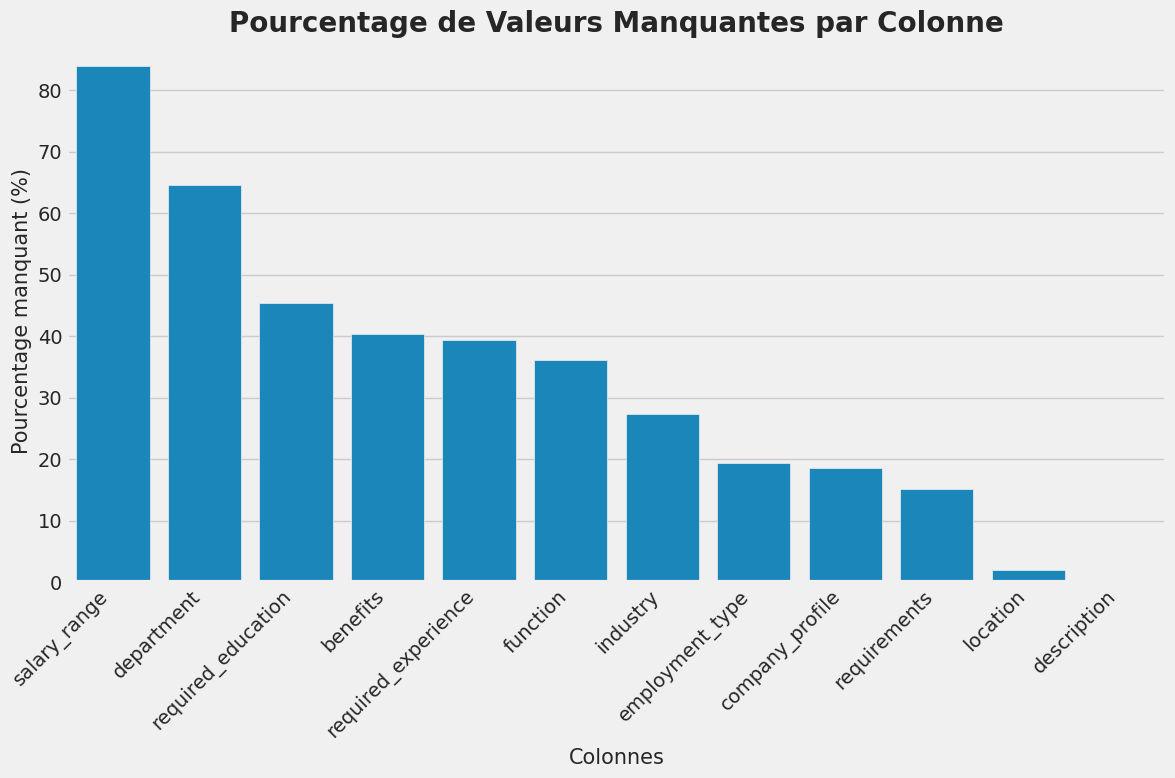

In [5]:
# Calculer le pourcentage de valeurs manquantes pour chaque colonne
missing_percentage = df.isnull().sum().sort_values(ascending=False) / len(df) * 100

# Filtrer pour ne garder que les colonnes avec des valeurs manquantes
missing_to_plot = missing_percentage[missing_percentage > 0]

# Créer la visualisation
plt.figure(figsize=(12, 8))
sns.barplot(x=missing_to_plot.index, y=missing_to_plot.values)
plt.title('Pourcentage de Valeurs Manquantes par Colonne', fontsize=20, fontweight='bold')
plt.xlabel('Colonnes', fontsize=15)
plt.ylabel('Pourcentage manquant (%)', fontsize=15)
plt.xticks(rotation=45, ha='right') # Améliore la lisibilité des noms de colonnes
plt.tight_layout() # Ajuste le graphique pour que tout soit visible
plt.show()

### Interprétation du graphique et Plan d'Action

Ce graphique révèle une hiérarchie claire dans les problèmes de données manquantes. Nous pouvons les classer en trois catégories pour définir notre stratégie de nettoyage.

*   **Code Rouge (Problème Critique > 60% manquant) :**
    *   `salary_range` (83.9% manquant) : Cette colonne est presque inutilisable en l'état. L'absence de salaire pourrait être en soi un indicateur de fraude.
    *   `department` (63.3% manquant) : Également très problématique. L'information est manquante pour près de 2 offres sur 3.

*   **Code Orange (Problème Significatif 20-50% manquant) :**
    *   `required_education`, `benefits`, `required_experience`, `function`, `industry` : Ce groupe représente le cœur de notre défi de nettoyage. Les informations sont trop précieuses pour être supprimées, mais trop incomplètes pour être utilisées directement.

*   **Code Jaune (Problème Gérable < 20% manquant) :**
    *   `employment_type`, `company_profile`, `requirements`, `location`, `description` : Ces colonnes ont un taux de complétion élevé. Les quelques valeurs manquantes peuvent probablement être gérées avec des techniques d'imputation simples ou en les laissant telles quelles.

**Conclusion Stratégique :**
La suppression pure et simple des lignes avec des valeurs manquantes est impossible, nous perdrions plus de 80% de nos données. Notre approche sera chirurgicale : nous traiterons chaque colonne ou groupe de colonnes avec une méthode adaptée.

---

Maintenant que le diagnostic est posé, on passe au traitement. Mais avant de toucher à la moindre colonne, il y a **UNE ÉTAPE CRUCIALE** dans tout problème de classification : **analyser la variable cible**.


## Étape 3 : Analyse de la Variable Cible ('fraudulent')

Avant tout nettoyage, il est impératif d'examiner la distribution de notre variable cible. Cela nous informera sur l'équilibre des classes et sur la pertinence des métriques d'évaluation que nous choisirons plus tard pour notre modèle de machine learning.

Distribution des offres d'emploi :
fraudulent
0    17014
1      866
Name: count, dtype: int64

Pourcentage de distribution :
fraudulent
0    95.1566
1     4.8434
Name: proportion, dtype: float64


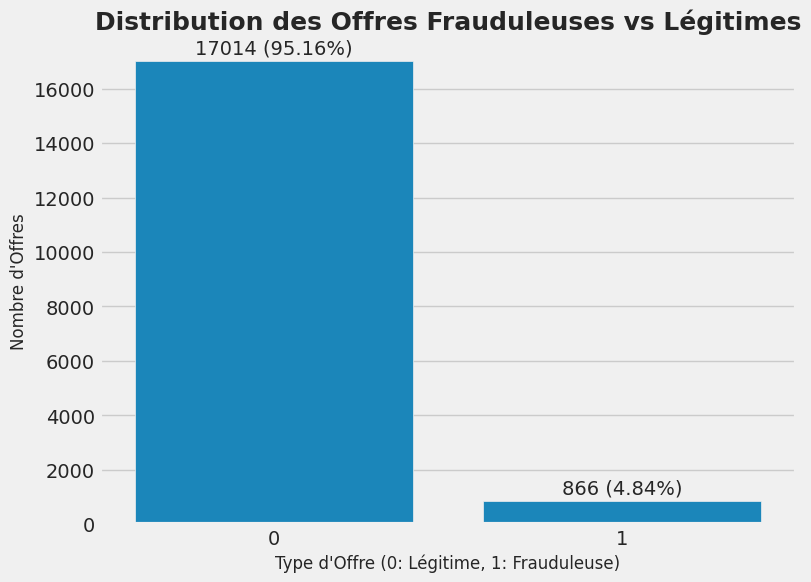

In [6]:
# Calculer la distribution de la variable 'fraudulent'
target_counts = df['fraudulent'].value_counts()
target_percentage = df['fraudulent'].value_counts(normalize=True) * 100

print("Distribution des offres d'emploi :")
print(target_counts)
print("\nPourcentage de distribution :")
print(target_percentage)

# Visualisation
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='fraudulent', data=df)
plt.title('Distribution des Offres Frauduleuses vs Légitimes', fontsize=18, fontweight='bold')
plt.xlabel('Type d\'Offre (0: Légitime, 1: Frauduleuse)', fontsize=12)
plt.ylabel('Nombre d\'Offres', fontsize=12)

# Ajouter les pourcentages sur les barres pour plus de clarté
for i, p in enumerate(ax.patches):
    percentage = target_percentage.iloc[i]
    ax.annotate(f'{int(p.get_height())} ({percentage:.2f}%)', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

plt.show()

### Interprétation de la Distribution

*   **Observation :** Le jeu de données est extrêmement déséquilibré. Les offres légitimes (classe 0) représentent 95.16% du total, tandis que les offres frauduleuses (classe 1) ne constituent qu'une infime minorité de 4.84%.

*   **Conclusion Stratégique :** Nous sommes face à un problème de "détection d'anomalies". Notre mission n'est pas simplement de classer, mais de trouver l'aiguille dans la botte de foin. Cela a deux implications majeures :
    1.  **Pour l'analyse :** Toute caractéristique qui semble commune dans le groupe des 866 offres frauduleuses est potentiellement un signal d'alerte très fort.
    2.  **Pour la modélisation :** L'accuracy sera une métrique inutile. Des métriques comme la **Précision**, le **Rappel (Recall)** et le **Score F1** seront essentielles pour évaluer correctement la performance d'un futur modèle.

## Étape 4 : Nettoyage & Ingénierie de Caractéristiques (Feature Engineering)

Nous allons maintenant traiter les colonnes une par une. Pour chaque colonne, nous allons :
1.  Gérer les valeurs manquantes avec une stratégie appropriée.
2.  Analyser sa relation avec la variable cible `fraudulent`.
3.  Créer de nouvelles caractéristiques si nécessaire.

### 4.1 Caractéristiques Binaires : `has_company_logo`, `has_questions`, `telecommuting`

Ces colonnes sont déjà propres (pas de valeurs manquantes, format binaire 0/1). Notre question est simple : les offres frauduleuses ont-elles tendance à avoir (ou ne pas avoir) ces attributs ?

Pourcentage d'offres avec chaque attribut, par classe :
            telecommuting  has_company_logo  has_questions
fraudulent                                                
0                4.131891         81.914894      50.205713
1                7.390300         32.678984      28.868360


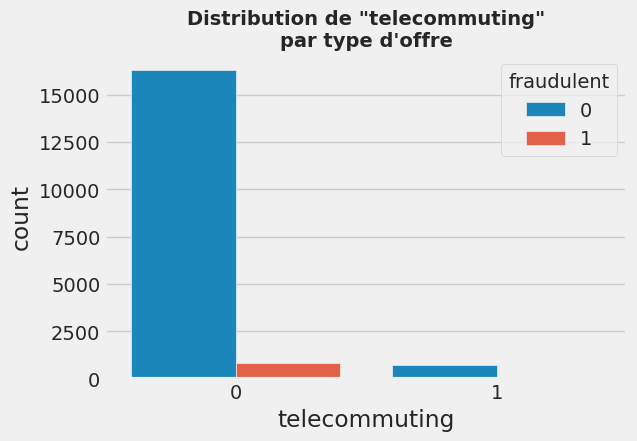

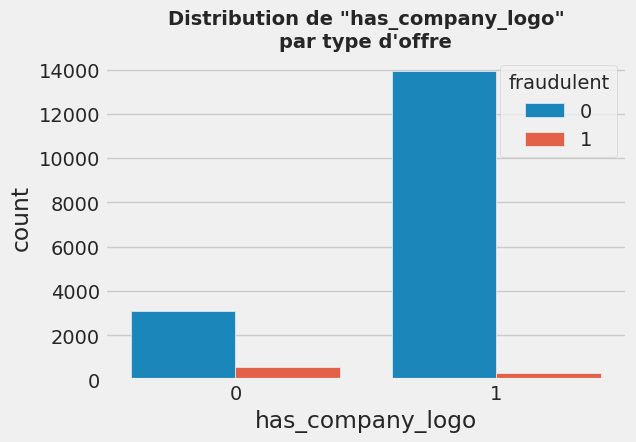

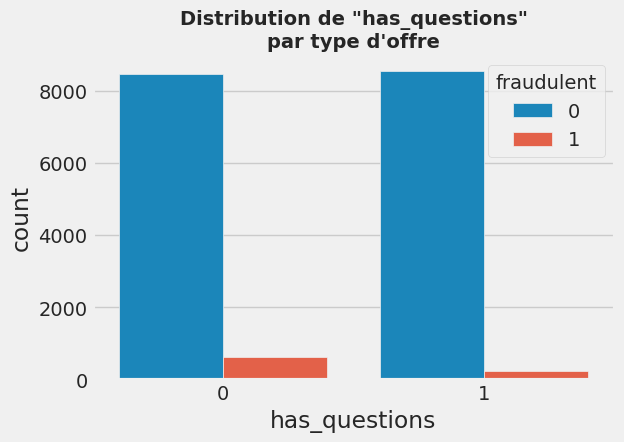

In [7]:
binary_cols = ['telecommuting', 'has_company_logo', 'has_questions']

# Comparons la moyenne de ces indicateurs pour les deux classes
# La moyenne d'une colonne 0/1 est équivalente au pourcentage de '1'
binary_comparison = df.groupby('fraudulent')[binary_cols].mean() * 100

print("Pourcentage d'offres avec chaque attribut, par classe :")
print(binary_comparison)

# Visualisation pour rendre la comparaison évidente
for col in binary_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, hue='fraudulent', data=df)
    plt.title(f'Distribution de "{col}"\npar type d\'offre', fontsize=14, fontweight='bold')
    plt.show()

### Interprétation des Caractéristiques Binaires

L'analyse de ces trois colonnes révèle des signaux d'alerte extrêmement clairs et puissants :

*   **`has_company_logo` : C'est le signal le plus fort.** Près de **82%** des offres légitimes ont un logo d'entreprise, contre seulement **33%** pour les offres frauduleuses. **Conclusion : L'absence d'un logo est un drapeau rouge majeur.**

*   **`has_questions` :** Un schéma similaire se dégage. **50%** des annonces légitimes incluent des questions de présélection, alors que seulement **29%** des annonces frauduleuses le font. **Conclusion : Les offres frauduleuses sont moins susceptibles de faire l'effort d'inclure des questions, ce qui est un autre indicateur de méfiance.**

*   **`telecommuting` :** La tendance s'inverse ici. Les offres frauduleuses sont presque deux fois plus susceptibles d'être des offres de télétravail (7.4%) que les offres légitimes (4.1%). **Conclusion : La promesse du télétravail peut être utilisée comme un appât par les fraudeurs.**

### 4.2 Variable Catégorielle : `employment_type` (Type de contrat)

Cette colonne est importante mais incomplète (~19% de valeurs manquantes). Nous allons d'abord imputer les valeurs manquantes puis analyser la distribution des types de contrats pour les offres légitimes et frauduleuses.

In [8]:
# Afficher les différentes catégories et leur fréquence, y compris les NaN
print("Distribution des types de contrats (avant nettoyage) :\n")
print(df['employment_type'].value_counts(dropna=False))

Distribution des types de contrats (avant nettoyage) :

employment_type
Full-time    11620
NaN           3471
Contract      1524
Part-time      797
Temporary      241
Other          227
Name: count, dtype: int64


In [9]:
# Stratégie d'imputation :
# Remplacer les valeurs manquantes (NaN) par une nouvelle catégorie "Unknown".
# C'est souvent mieux que de deviner, car le fait que l'information soit manquante peut être un signal en soi.

df['employment_type'] = df['employment_type'].fillna('Unknown')

print("\nDistribution des types de contrats (après nettoyage) :\n")
print(df['employment_type'].value_counts())


Distribution des types de contrats (après nettoyage) :

employment_type
Full-time    11620
Unknown       3471
Contract      1524
Part-time      797
Temporary      241
Other          227
Name: count, dtype: int64


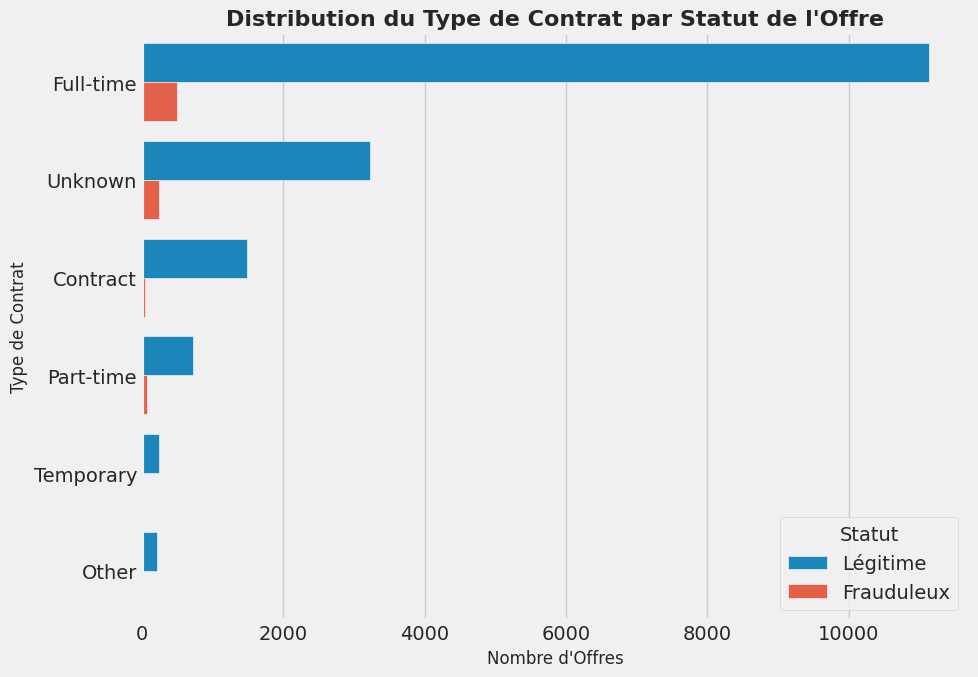

In [10]:
# Visualisons maintenant comment les types de contrat se répartissent entre les offres frauduleuses et légitimes.

plt.figure(figsize=(10, 7))
sns.countplot(y='employment_type', hue='fraudulent', data=df, order=df['employment_type'].value_counts().index)
plt.title('Distribution du Type de Contrat par Statut de l\'Offre', fontsize=16, fontweight='bold')
plt.xlabel('Nombre d\'Offres', fontsize=12)
plt.ylabel('Type de Contrat', fontsize=12)
plt.legend(title='Statut', labels=['Légitime', 'Frauduleux'])
plt.tight_layout()
plt.show()

### Interprétation de `employment_type`

*   **Observation 1 :** La catégorie `Full-time` est la plus fréquente, tant pour les offres légitimes que frauduleuses.
*   **Observation 2 :** Notre imputation a créé la catégorie `Unknown` qui est la deuxième plus grande, indiquant que le manque d'information sur le type de contrat est un phénomène courant dans ce dataset.
*   **Limite de cette visualisation :** À cause du grand déséquilibre, il est difficile de comparer le **risque** de fraude entre les catégories. La barre orange pour `Full-time` est la plus grande, mais cela ne veut pas dire que c'est la catégorie la plus risquée en proportion. Pour répondre à cette question, nous devons normaliser les données.

### 4.2.1 Analyse Approfondie : Risque de Fraude par Type de Contrat

Pour obtenir une vision claire du risque, nous allons calculer le pourcentage d'offres frauduleuses pour chaque type de contrat.

Pourcentage de fraude par type de contrat :
fraudulent               0         1
employment_type                     
Part-time        90.715182  9.284818
Unknown          93.056756  6.943244
Other            93.392070  6.607930
Full-time        95.783133  4.216867
Contract         97.112861  2.887139
Temporary        99.170124  0.829876


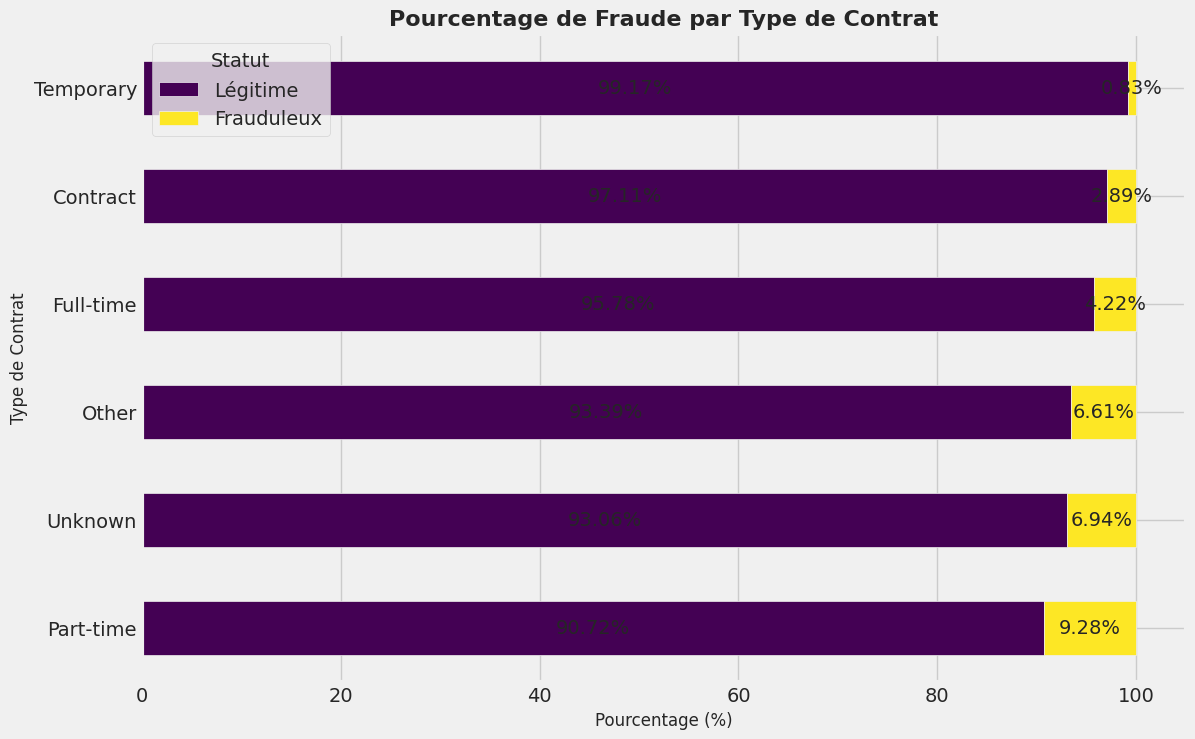

In [11]:
# Calculer la table de contingence et normaliser par ligne ('index') pour obtenir des pourcentages
employment_risk = pd.crosstab(df['employment_type'], df['fraudulent'], normalize='index') * 100
employment_risk = employment_risk.sort_values(by=1, ascending=False) # Trier par le % de fraude

print("Pourcentage de fraude par type de contrat :")
print(employment_risk)

# Visualisation en barres empilées
ax = employment_risk.plot(kind='barh', stacked=True, figsize=(12, 8), colormap='viridis')

plt.title('Pourcentage de Fraude par Type de Contrat', fontsize=16, fontweight='bold')
plt.xlabel('Pourcentage (%)', fontsize=12)
plt.ylabel('Type de Contrat', fontsize=12)
plt.legend(title='Statut', labels=['Légitime', 'Frauduleux'])

# Ajouter les annotations de pourcentage pour la classe frauduleuse (1)
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    if width > 0: # Ne pas annoter les barres de taille 0
        ax.text(x + width/2, 
                y + height/2, 
                f'{width:.2f}%', 
                ha='center', 
                va='center')

plt.show()

### Interprétation Finale (Basée sur les Pourcentages)

*   **Conclusion Principale :** L'analyse en proportion révèle une réalité cachée. Ce n'est pas le type `Full-time` qui est le plus risqué, mais le **`Part-time` (Temps partiel)**, où près de **1 offre sur 10 (9.28%)** est frauduleuse.

*   **Hiérarchie du Risque :**
    1.  **Haut Risque :** `Part-time` (9.28%)
    2.  **Risque Modéré :** `Unknown` (6.94%) et `Other` (6.61%).
    3.  **Faible Risque :** `Full-time` (4.22%), `Contract` (2.89%), et `Temporary` (0.83%).

*   **Insight Actionnable :** Le manque d'information (`Unknown`) est un facteur de risque plus élevé que la moyenne. Les offres d'emploi à temps partiel (`Part-time`) devraient être systématiquement considérées comme suspectes et potentiellement soumises à une vérification plus approfondie.

### 4.3 Analyse de Texte : `company_profile` (Profil de l'entreprise)

Le profil de l'entreprise est une mine d'informations potentielles. Un profil vide, ou au contraire un profil générique copié-collé, peut être un signe de fraude. Nous allons commencer par analyser la **longueur** du profil.

In [12]:
# Remplacer les NaN par une chaîne de caractères vide pour pouvoir calculer la longueur
df['company_profile_filled'] = df['company_profile'].fillna('')

# Créer une nouvelle colonne avec la longueur du profil
df['profile_length'] = df['company_profile_filled'].apply(len)

# Afficher les statistiques de base de cette nouvelle colonne
print("Statistiques descriptives de la longueur du profil d'entreprise :")
print(df['profile_length'].describe())

Statistiques descriptives de la longueur du profil d'entreprise :
count    17880.000000
mean       620.901454
std        567.454100
min          0.000000
25%        138.000000
50%        570.000000
75%        879.000000
max       6178.000000
Name: profile_length, dtype: float64


Maintenant, nous allons visualiser comment cette longueur se répartit entre les offres légitimes et frauduleuses. Un KDE (Kernel Density Estimate) plot est parfait pour comparer des distributions de variables continues.

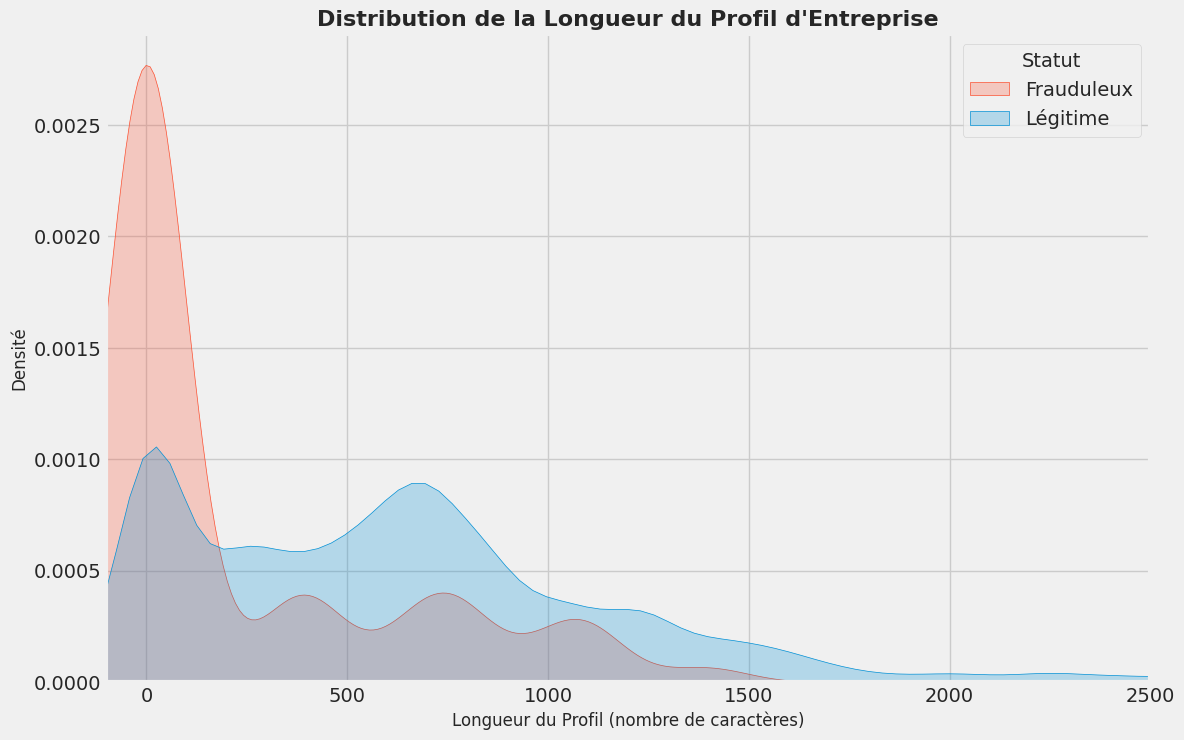

In [13]:
plt.figure(figsize=(12, 8))
sns.kdeplot(data=df, x='profile_length', hue='fraudulent', fill=True, common_norm=False)
plt.title('Distribution de la Longueur du Profil d\'Entreprise', fontsize=16, fontweight='bold')
plt.xlabel('Longueur du Profil (nombre de caractères)', fontsize=12)
plt.ylabel('Densité', fontsize=12)
plt.legend(title='Statut', labels=['Frauduleux', 'Légitime']) # L'ordre peut varier, vérifiez la couleur

# On limite l'axe des x pour mieux voir, car il y a des profils très longs (outliers)
plt.xlim(-100, 2500)
plt.show()

### Interprétation de la Longueur du Profil

Ce graphique de densité révèle deux comportements radicalement différents entre les recruteurs légitimes et les fraudeurs :

*   **Observation 1 (Le Pic à Zéro - Le Signal d'Alarme) :** Le graphique montre de manière spectaculaire que la grande majorité des offres frauduleuses (courbe orange) n'ont **aucun profil d'entreprise** (longueur = 0). Le pic de densité pour les offres frauduleuses à x=0 est massivement plus élevé que celui des offres légitimes. Cela signifie qu'un profil d'entreprise manquant est un indicateur de fraude extrêmement puissant.

*   **Observation 2 (La Faiblesse du Contenu) :** Lorsque les offres frauduleuses daignent inclure un profil, il est presque toujours très court. La distribution des offres légitimes (courbe bleue) est beaucoup plus étalée, avec plusieurs pics entre 250 et 1500 caractères, ce qui correspond à des descriptions d'entreprise saines et variées. La courbe des offres frauduleuses, en revanche, s'effondre rapidement après le pic initial.

*   **Conclusion Stratégique :** Nous avons deux nouvelles caractéristiques (features) très prometteuses pour notre futur modèle :
    1.  **`has_company_profile` (binaire) :** Une simple variable Vrai/Faux indiquant si un profil existe.
    2.  **`profile_length` (numérique) :** La longueur du profil, où les valeurs très faibles sont suspectes.
    
    Les fraudeurs adoptent une stratégie de "faible effort" : soit ils ne fournissent pas de profil du tout, soit ils fournissent un texte minimaliste.

### 4.4 Analyse de la Longueur des Autres Champs de Texte

Nous allons appliquer la même technique d'analyse de longueur aux colonnes `description`, `requirements` et `benefits` pour voir si la stratégie de "faible effort" des fraudeurs se confirme.

In [14]:
# Liste des colonnes de texte à analyser
text_cols = ['description', 'requirements', 'benefits']

# Boucle pour créer une colonne de longueur pour chaque champ de texte
for col in text_cols:
    # Remplacer les NaN par une chaîne vide
    df[col] = df[col].fillna('')
    # Créer la nouvelle colonne de longueur
    df[f'{col}_length'] = df[col].apply(len)

# Afficher un aperçu des nouvelles colonnes
df[[f'{col}_length' for col in text_cols]].describe()

,description_length,requirements_length,benefits_length
count,17880.000000,17880.000000,17880.000000
mean,1218.004418,590.132215,208.895694
std,894.828620,613.191270,337.077357
min,0.000000,0.000000,0.000000
25%,607.000000,146.000000,0.000000
50%,1017.000000,467.000000,45.000000
75%,1586.000000,820.000000,294.000000
max,14907.000000,10864.000000,4429.000000


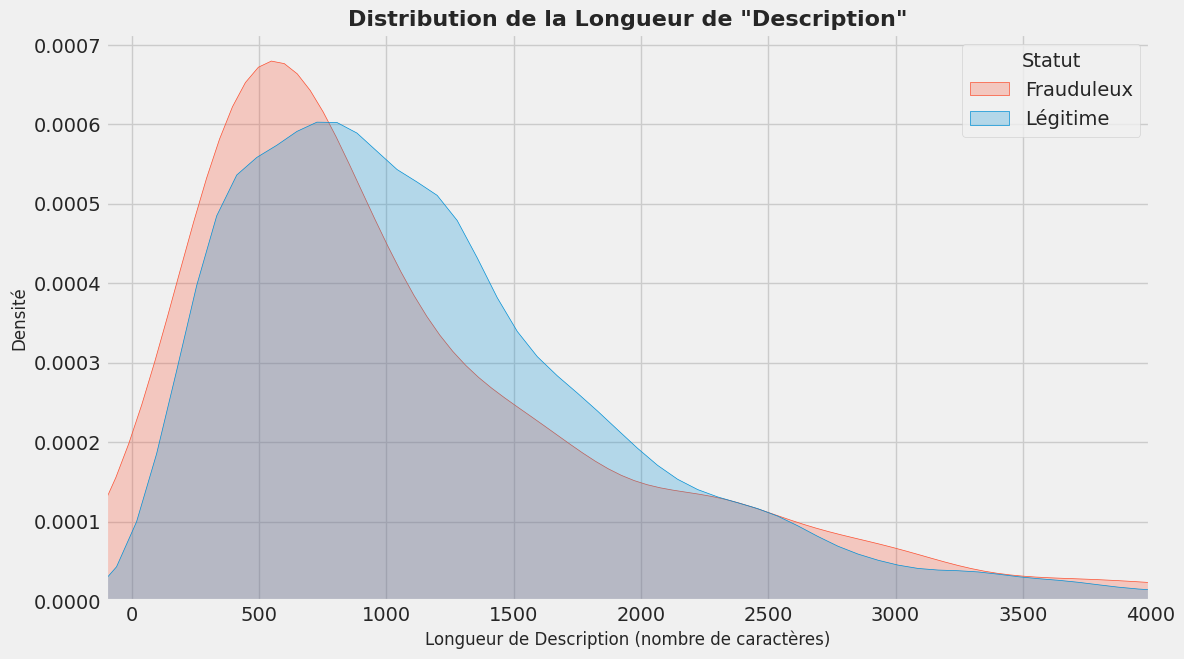

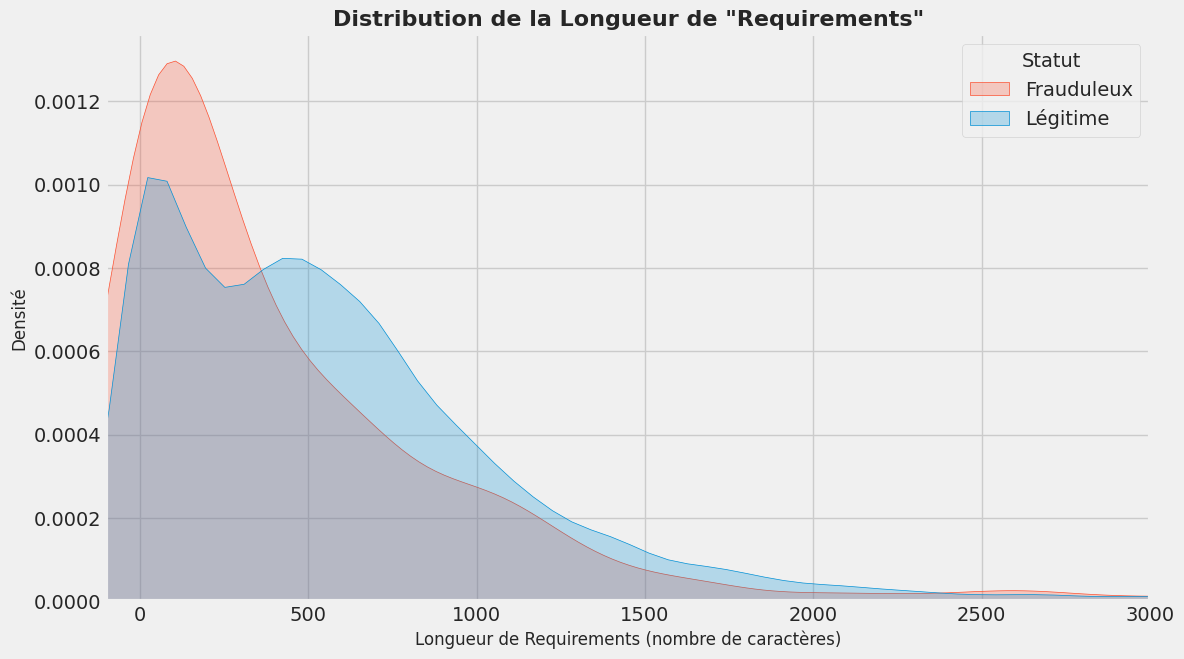

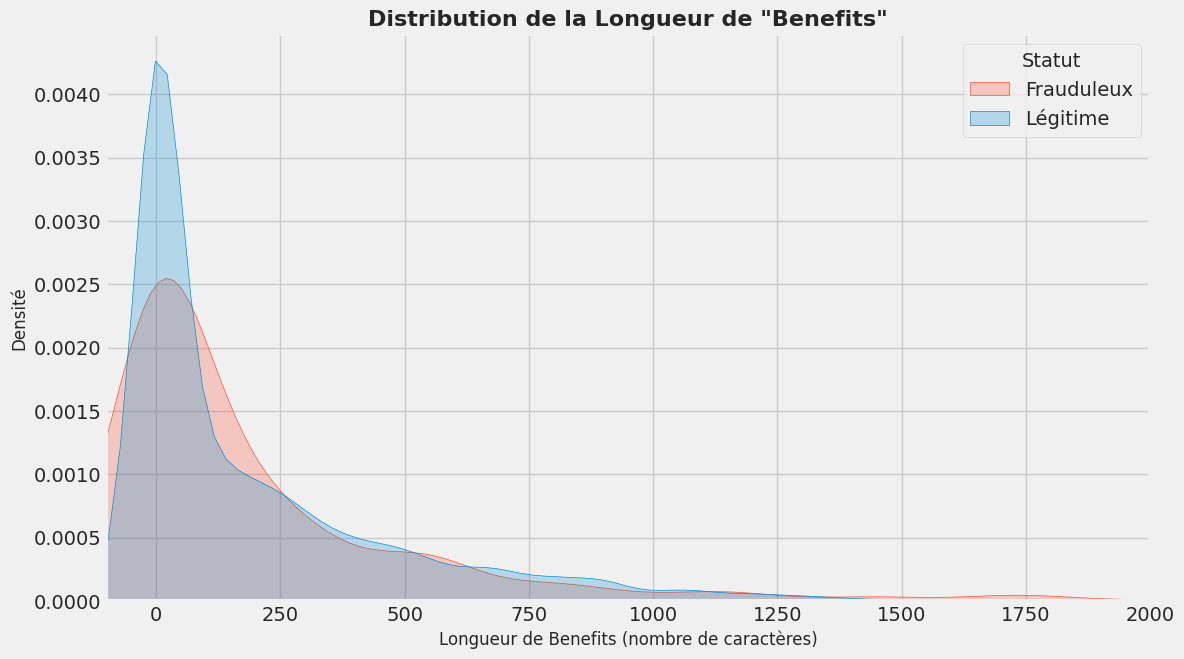

In [15]:
# Boucle pour créer un KDE plot pour chaque nouvelle colonne de longueur
for col in text_cols:
    plt.figure(figsize=(12, 7))
    sns.kdeplot(data=df, x=f'{col}_length', hue='fraudulent', fill=True, common_norm=False)
    plt.title(f'Distribution de la Longueur de "{col.capitalize()}"', fontsize=16, fontweight='bold')
    plt.xlabel(f'Longueur de {col.capitalize()} (nombre de caractères)', fontsize=12)
    plt.ylabel('Densité', fontsize=12)
    plt.legend(title='Statut', labels=['Frauduleux', 'Légitime'])
    
    # Limiter l'axe des x pour une meilleure lisibilité
    # Ces valeurs peuvent être ajustées si le graphique est illisible
    if col == 'description':
        plt.xlim(-100, 4000)
    elif col == 'requirements':
        plt.xlim(-100, 3000)
    else:
        plt.xlim(-100, 2000)
        
    plt.show()

### Interprétation Finale de l'Analyse de Longueur

*   **Tendance Générale Confirmée :** Les graphiques pour `description`, `requirements`, et `benefits` confirment tous la même tendance observée pour `company_profile`.

*   **`Description` :** La courbe des offres frauduleuses est nettement décalée vers la gauche. Cela indique que, en moyenne, **les descriptions de poste frauduleuses sont significativement plus courtes** que celles des offres légitimes. Les recruteurs légitimes investissent plus de temps dans la rédaction de descriptions détaillées.

*   **`Requirements` & `Benefits` (Le signal d'alarme) :** Ces deux graphiques montrent un comportement extrême. Les offres frauduleuses présentent un pic de densité massif à zéro. Cela signifie que **la grande majorité des offres frauduleuses n'incluent tout simplement pas de section "Exigences" ou "Avantages"**. C'est un signal de faible effort et un drapeau rouge majeur.

*   **Conclusion Stratégique :** Nous avons maintenant créé un ensemble de 5 caractéristiques numériques (`profile_length`, `description_length`, etc.) qui sont toutes de puissants indicateurs de fraude potentielle. Un modèle de machine learning pourra très efficacement utiliser ces "méta-caractéristiques" pour distinguer les offres.

### 4.5 Analyse de la Localisation (`location`)

La localisation peut être un indicateur clé. Certains lieux sont-ils plus ciblés par les offres frauduleuses ? Nous allons nettoyer cette colonne et analyser les lieux les plus fréquents pour chaque classe.

In [16]:
# Imputer les quelques valeurs manquantes avec "Unknown"
df['location'] = df['location'].fillna('Unknown')

# La colonne 'location' est souvent au format "Pays, État, Ville" (ex: "US, NY, New York").
# Pour une première analyse, extrayons simplement le pays (les deux premières lettres).
# Nous créons une nouvelle colonne 'country'.

# La fonction .str[:2] prend les deux premiers caractères de la chaîne.
df['country'] = df['location'].str[:2]

print("Pays les plus fréquents dans le dataset :")
print(df['country'].value_counts().head(10))

Pays les plus fréquents dans le dataset :
country
US    10656
GB     2384
GR      940
CA      457
DE      383
Un      346
NZ      333
IN      276
AU      214
PH      132
Name: count, dtype: int64


Analysons maintenant les 15 pays les plus fréquents et voyons comment les offres frauduleuses s'y répartissent.

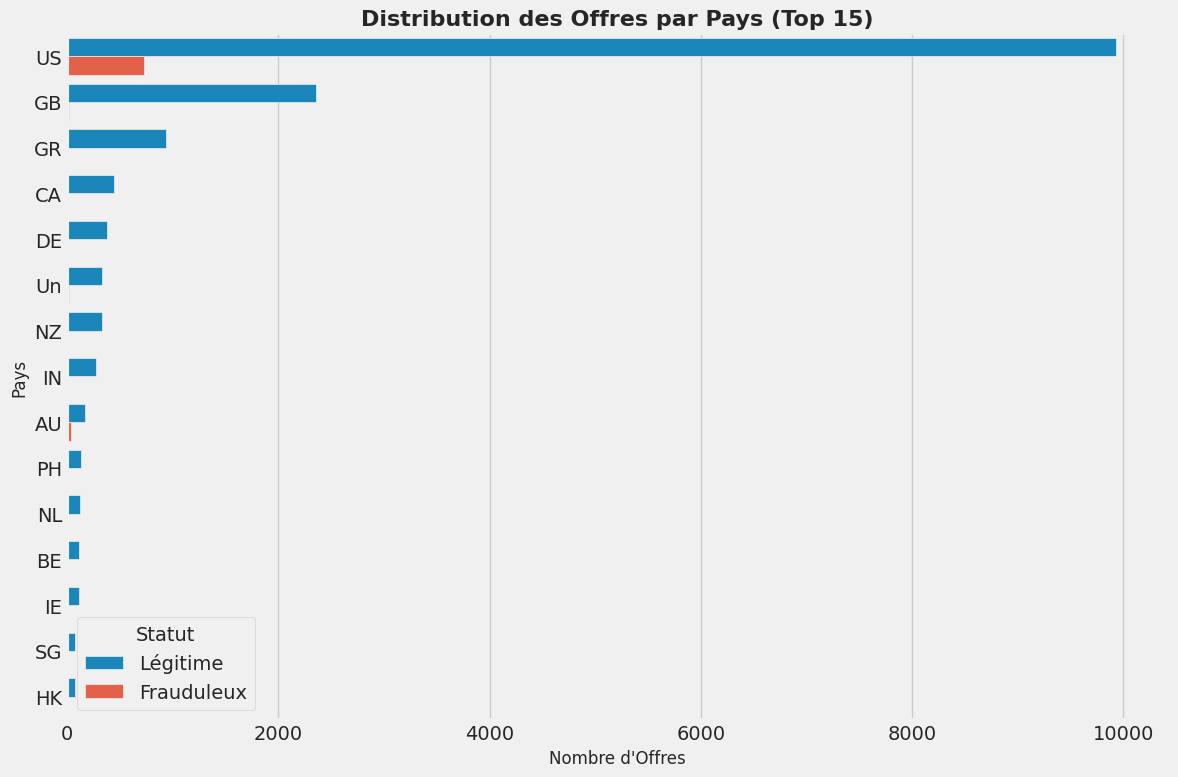

In [17]:
# Identifier les 15 pays les plus fréquents
top_countries = df['country'].value_counts().nlargest(15).index

# Filtrer le DataFrame pour ne garder que ces pays
df_top_countries = df[df['country'].isin(top_countries)]

# Créer le graphique
plt.figure(figsize=(12, 8))
sns.countplot(y='country', hue='fraudulent', data=df_top_countries, order=top_countries)
plt.title('Distribution des Offres par Pays (Top 15)', fontsize=16, fontweight='bold')
plt.xlabel('Nombre d\'Offres', fontsize=12)
plt.ylabel('Pays', fontsize=12)
plt.legend(title='Statut', labels=['Légitime', 'Frauduleux'])
plt.tight_layout()
plt.show()

### Interprétation de la Localisation

*   **Observation 1 :** Les États-Unis (US) représentent la grande majorité des offres dans ce dataset, avec plus de 10 000 annonces. Le Royaume-Uni (GB) est le deuxième pays le plus représenté, mais avec une présence bien moindre.
*   **Observation 2 :** La plupart des offres frauduleuses en nombre absolu se trouvent aux États-Unis, ce qui est logique étant donné leur surreprésentation.
*   **Limite de l'approche :** Notre extraction du pays (`.str[:2]`) est une simplification. Une catégorie comme "Un" correspond probablement à notre imputation "Unknown". De plus, ce graphique ne nous permet pas de comparer le **risque** de fraude entre les pays. Nous devons normaliser.

### 4.5.1 Analyse Approfondie : Risque de Fraude par Pays

Nous calculons maintenant le pourcentage d'offres frauduleuses pour chaque pays afin de comparer le risque relatif, indépendamment du nombre total d'offres.

Pourcentage de fraude par pays (pour les pays avec >= 50 offres) :
fraudulent           0          1
country                          
AU           81.308411  18.691589
US           93.149399   6.850601
Un           94.508671   5.491329
PL           96.052632   3.947368
CA           97.374179   2.625821
EG           98.076923   1.923077
AE           98.148148   1.851852
ES           98.484848   1.515152
IN           98.550725   1.449275
EE           98.611111   1.388889
GB           99.035235   0.964765
PH           99.242424   0.757576
DE          100.000000   0.000000
BE          100.000000   0.000000
IL          100.000000   0.000000
IE          100.000000   0.000000
HK          100.000000   0.000000
GR          100.000000   0.000000
FR          100.000000   0.000000
NL          100.000000   0.000000
NZ          100.000000   0.000000
SG          100.000000   0.000000


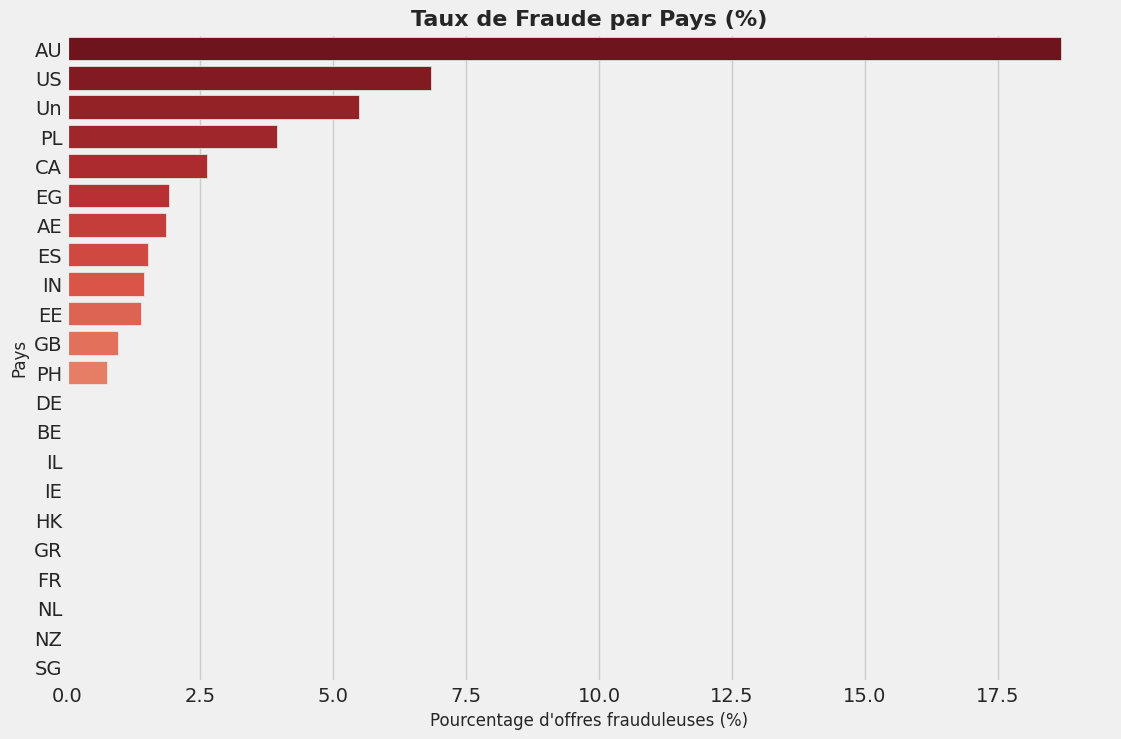

In [18]:
# Nous allons nous concentrer sur les pays avec au moins 50 offres pour avoir des pourcentages un peu plus stables
country_counts = df['country'].value_counts()
countries_to_analyze = country_counts[country_counts >= 50].index

df_filtered_countries = df[df['country'].isin(countries_to_analyze)]

# Calculer la table de contingence et normaliser
country_risk = pd.crosstab(df_filtered_countries['country'], df_filtered_countries['fraudulent'], normalize='index') * 100
country_risk = country_risk.sort_values(by=1, ascending=False) # Trier par le % de fraude (colonne 1)

print("Pourcentage de fraude par pays (pour les pays avec >= 50 offres) :")
print(country_risk)


# Visualisation avec une palette de couleurs liée à la valeur (plus rouge = plus risqué)
plt.figure(figsize=(12, 8))
# On assigne la variable de l'axe y à 'hue' pour lier la palette de couleurs aux pays
sns.barplot(x=country_risk[1], y=country_risk.index, hue=country_risk.index, orient='h', palette='Reds_r', legend=False)

plt.title('Taux de Fraude par Pays (%)', fontsize=16, fontweight='bold')
plt.xlabel('Pourcentage d\'offres frauduleuses (%)', fontsize=12)
plt.ylabel('Pays', fontsize=12)
plt.show()

### Interprétation Finale de la Localisation

*   **Conclusion Principale :** L'analyse du taux de fraude révèle une hiérarchie du risque totalement différente du volume d'offres. C'est en **Australie (AU)** que le risque est le plus élevé, avec un taux de fraude alarmant de **18.7%**, soit près d'une offre sur cinq.

*   **Hiérarchie du Risque :**
    1.  **Risque Extrême :** Australie (AU) à 18.7%.
    2.  **Risque Élevé :** États-Unis (US) à 6.9%.
    3.  **Risque Notable :** Les offres sans pays clair (`Un`) et la Pologne (PL) présentent également un risque supérieur à la moyenne.
    4.  **Risque Faible ou Nul :** De nombreux pays, notamment en Europe (DE, GR, FR, NL) et en Océanie (NZ), présentent un taux de fraude nul dans notre échantillon analysé.

*   **Insight Actionnable :** La variable `country` est un prédicteur extrêmement puissant. Un modèle de risque devrait attribuer un poids très important à une offre provenant d'Australie. Cela suggère l'existence de campagnes de fraude ciblées géographiquement.

### 4.6 Analyse des Colonnes à Fort Taux de Manque : `salary_range`

La colonne `salary_range` est manquante dans plus de 83% des cas. Tenter de "deviner" ou d'imputer un salaire serait trop hasardeux. Cependant, nous pouvons tester l'hypothèse que **l'absence d'une fourchette de salaire est, en soi, un indicateur de fraude**. Les recruteurs légitimes sont souvent plus transparents sur la rémunération.

Nous allons donc créer une nouvelle caractéristique binaire : `has_salary_range`.

Pourcentage d'offres avec une fourchette de salaire, par classe :
fraudulent
0    15.546021
1    25.750577
Name: has_salary_range, dtype: float64


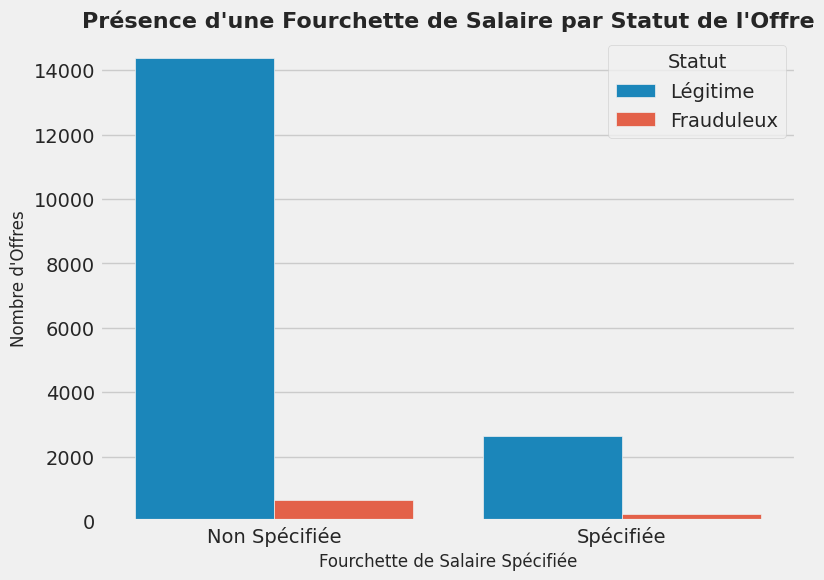

In [23]:
# Créer la caractéristique binaire (1 si le salaire est présent, 0 sinon)
df['has_salary_range'] = df['salary_range'].notna().astype(int)

# Comparer le taux de présence de la fourchette de salaire par classe
salary_presence_comparison = df.groupby('fraudulent')['has_salary_range'].mean() * 100
print("Pourcentage d'offres avec une fourchette de salaire, par classe :")
print(salary_presence_comparison)

# Visualisation
plt.figure(figsize=(8, 6))
sns.countplot(x='has_salary_range', hue='fraudulent', data=df)
plt.title('Présence d\'une Fourchette de Salaire par Statut de l\'Offre', fontsize=16, fontweight='bold')
plt.xlabel('Fourchette de Salaire Spécifiée', fontsize=12)
plt.ylabel('Nombre d\'Offres', fontsize=12)
plt.xticks([0, 1], ['Non Spécifiée', 'Spécifiée'])
plt.legend(title='Statut', labels=['Légitime', 'Frauduleux'])
plt.show()

### Interprétation de `has_salary_range`

*   **Observation :** L'analyse révèle un comportement inattendu. **25.8%** des offres frauduleuses spécifient une fourchette de salaire, contre seulement **15.5%** pour les offres légitimes.

Les fraudeurs ne sont pas seulement paresseux, ils sont stratégiques. Ils savent qu'une fourchette de salaire attractive est un appât puissant pour attirer des candidats. Ils n'ont aucune contrainte RH, ils peuvent inventer n'importe quel chiffre pour rendre leur offre alléchante.

*   **Conclusion Stratégique :** Notre hypothèse de "faible effort" doit être nuancée. Si les fraudeurs sont moins enclins à fournir des détails complexes (profil, exigences), ils sont **plus enclins à spécifier un salaire**. Cela suggère que la mention d'un salaire est utilisée comme un **appât stratégique** pour attirer un maximum de candidats. La présence d'une fourchette de salaire, loin d'être un gage de confiance, pourrait donc être, dans certains contextes, un signal de risque.

### Analyse du Taux de Risque lié à la Présence du Salaire

Pour confirmer cette découverte, calculons le taux de fraude dans les deux groupes : ceux avec et ceux sans fourchette de salaire spécifiée.

Taux de fraude selon la présence d'une fourchette de salaire :

fraudulent                0         1
has_salary_range                     
0                 95.716760  4.283240
1                 92.224547  7.775453


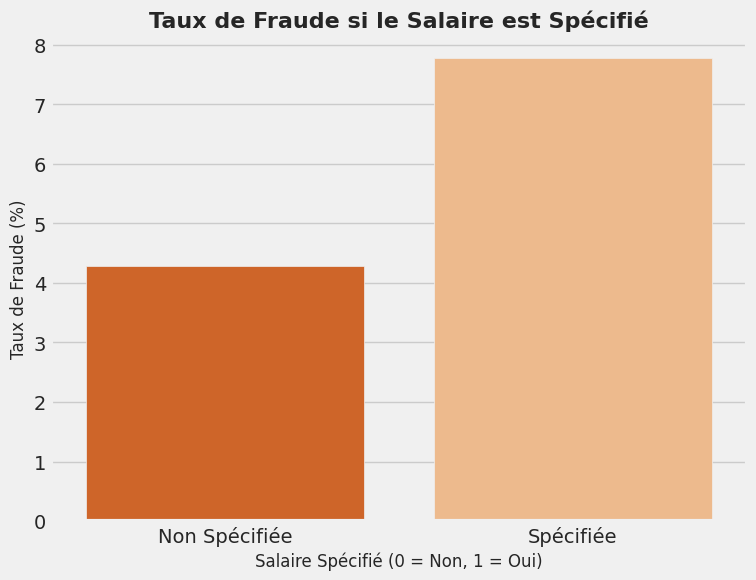

In [25]:
salary_risk = pd.crosstab(df['has_salary_range'], df['fraudulent'], normalize='index') * 100

print("Taux de fraude selon la présence d'une fourchette de salaire :\n")
print(salary_risk)

# Visualisation du risque (Syntaxe Corrigée)
plt.figure(figsize=(8, 6))
sns.barplot(x=salary_risk.index, y=salary_risk[1], hue=salary_risk.index, palette='Oranges_r', legend=False)
plt.title('Taux de Fraude si le Salaire est Spécifié', fontsize=16, fontweight='bold')
plt.xlabel('Salaire Spécifié (0 = Non, 1 = Oui)', fontsize=12)
plt.ylabel('Taux de Fraude (%)', fontsize=12)
plt.xticks([0, 1], ['Non Spécifiée', 'Spécifiée'])
plt.show()

### Interprétation Finale du Risque lié au Salaire

*   **Confirmation :** Le graphique du taux de risque confirme notre découverte contre-intuitive de manière éclatante. Le taux de fraude pour les offres **spécifiant un salaire est de 7.8%**, ce qui est significativement plus élevé que le taux de **4.3%** pour les offres ne le spécifiant pas.

*   **Insight Actionnable :** La présence d'une fourchette de salaire, loin d'être un gage de confiance, doit être considérée comme un facteur de risque. Les fraudeurs l'utilisent manifestement comme un appât pour attirer les candidats avec des promesses potentiellement irréalistes. La nouvelle caractéristique `has_salary_range` est donc un excellent prédicteur de fraude.

## Étape 5 : Synthèse et Création du Dataset Prêt pour la Modélisation

Nous avons terminé notre analyse exploratoire. Nous allons maintenant sélectionner les colonnes pertinentes et les nouvelles caractéristiques que nous avons créées pour former un jeu de données final, propre et prêt à être utilisé par un algorithme de machine learning.

In [ ]:
# Affichons toutes les colonnes que nous avons maintenant
print("Toutes les colonnes disponibles :")
print(df.columns)

# Sélectionnons les colonnes originales utiles et nos nouvelles 'features'
features_to_keep = [
    # Caractéristiques catégorielles nettoyées
    'employment_type',
    'country',
    
    # Caractéristiques binaires originales
    'telecommuting',
    'has_company_logo',
    'has_questions',
    
    # Nouvelle caractéristique binaire
    'has_salary_range',
    
    # Caractéristiques de longueur (très importantes !)
    'profile_length',
    'description_length',
    'requirements_length',
    'benefits_length',
    
    # Et bien sûr enfin notre variable cible !
    'fraudulent'
]

# Création du DataFrame final
df_model = df[features_to_keep].copy()

print("\n" + "="*80 + "\n")
print("Aperçu du jeu de données final prêt pour la modélisation :")
df_model.head()

Toutes les colonnes disponibles :
Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'company_profile_filled', 'profile_length',
       'description_length', 'requirements_length', 'benefits_length',
       'country', 'has_salary_range'],
      dtype='object')


Aperçu du jeu de données final prêt pour la modélisation :


,employment_type,country,telecommuting,has_company_logo,has_questions,has_salary_range,profile_length,description_length,requirements_length,benefits_length,fraudulent
0,Other,US,0,1,0,0,885,905,852,0,0
1,Full-time,NZ,0,1,0,0,1286,2077,1433,1292,0
2,Unknown,US,0,1,0,0,879,355,1363,0,0
3,Full-time,US,0,1,0,0,614,2600,1429,782,0
4,Full-time,US,0,1,1,0,1628,1520,757,21,0


In [21]:
# Une dernière vérification pour s'assurer qu'il n'y a plus de valeurs manquantes
print("Vérification des valeurs manquantes dans le dataset final :")
df_model.info()

Vérification des valeurs manquantes dans le dataset final :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   employment_type      17880 non-null  object
 1   country              17880 non-null  object
 2   telecommuting        17880 non-null  int64 
 3   has_company_logo     17880 non-null  int64 
 4   has_questions        17880 non-null  int64 
 5   has_salary_range     17880 non-null  int64 
 6   profile_length       17880 non-null  int64 
 7   description_length   17880 non-null  int64 
 8   requirements_length  17880 non-null  int64 
 9   benefits_length      17880 non-null  int64 
 10  fraudulent           17880 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 1.5+ MB


## Étape 6 : Sauvegarde du Dataset Nettoyé

Nous sauvegardons le DataFrame final dans un nouveau fichier CSV.
Il sera prêt pour la phase de modélisation.

In [22]:
# Créer le dossier s'il n'existe pas
import os
if not os.path.exists('data/processed'):
    os.makedirs('data/processed')

df_model.to_csv('data/processed/cleaned_job_postings.csv', index=False)

print("Le jeu de données nettoyé a été sauvegardé avec succès dans 'data/processed/cleaned_job_postings.csv'")

Le jeu de données nettoyé a été sauvegardé avec succès dans 'data/processed/cleaned_job_postings.csv'
